# This is my first CNN Model using PyTorch 

In [2]:
import pandas as pd
import numpy as np
import os 

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import WeightedRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## 1. Data Loading and Preprocessing
First, we'll define the code for loading and preprocessing the data. This involves normalizing the tensors and splitting the dataset into training and validation sets.

### Dataset Preparation with Balancing

In [5]:
#define my path in hard drive
# Windows
# data_dir = "S:/Capston/data2"
data_dir = "S:/Capston/data2"
# My 3D tensor files directory
# SAVE_FOLDER = "S:/Capston/data4"
SAVE_FOLDER = "S:/Capston/data4"

In [6]:
# Read CSV and making dataframe
df = pd.read_csv(os.path.join(data_dir,'patients_meta_plus_path.csv'))
# sanity check
df.shape

(3147, 16)

In [7]:
df.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,paths
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,S:\Capston\data4\10004.pt
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0,S:\Capston\data4\10005.pt
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0,S:\Capston\data4\10007.pt
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0,S:\Capston\data4\10026.pt
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1,S:\Capston\data4\10051.pt


In [8]:
df.columns

Index(['patient_id', 'bowel_healthy', 'bowel_injury', 'extravasation_healthy',
       'extravasation_injury', 'kidney_healthy', 'kidney_low', 'kidney_high',
       'liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy',
       'spleen_low', 'spleen_high', 'any_injury', 'paths'],
      dtype='object')

In [9]:
df = df.drop(columns=['bowel_healthy', 'extravasation_healthy',
       'extravasation_injury','any_injury'])

In [10]:
# Splitting the dataset
remain_df, test_df = train_test_split(df, test_size=0.2, random_state=42)  # 20% data for testing
train_df, val_df = train_test_split(remain_df, test_size=0.25, random_state=42)  # 60% training, 20% validation

# Balancing the training dataset
class_counts = train_df[['bowel_injury', 'kidney_healthy', 'kidney_low', 'kidney_high',
       'liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy',
       'spleen_low', 'spleen_high']].sum().values
num_samples = len(train_df)
weights = 1. / class_counts
samples_weights = weights[train_df[['bowel_injury', 'kidney_healthy', 'kidney_low', 'kidney_high',
       'liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy',
       'spleen_low', 'spleen_high']].values.argmax(axis=1)]
sampler = WeightedRandomSampler(samples_weights, num_samples)


In [11]:
class CTScanDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        """
        Args:
            dataframe (DataFrame): DataFrame containing the file paths and labels.
            root_dir (string): Directory with all the tensor files.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, -1])
        # ... load the image ...
        image = torch.load(img_name)
        # Add a channel dimension
        image = image.unsqueeze(0)  # This adds a channel dimension
        labels = self.dataframe.iloc[idx, 1:-1].values
        labels = torch.from_numpy(labels.astype('float')).float()

        if self.transform:
            image = self.transform(image)

        return image, labels

# Dataset and DataLoader
train_dataset = CTScanDataset(train_df, SAVE_FOLDER)
val_dataset = CTScanDataset(val_df, SAVE_FOLDER)
test_dataset = CTScanDataset(test_df, SAVE_FOLDER)

train_loader = DataLoader(train_dataset, batch_size=4, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


## 2. CNN Model Architecture
Next, we'll define a simple 3D CNN model architecture.

In [12]:
class Simple3DCNN(nn.Module):
    def __init__(self):
        super(Simple3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, 3)  # Set input channels to 1
        self.pool = nn.MaxPool3d(2, 2)
        self.conv2 = nn.Conv3d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 30 * 30 * 30, 120)  # Adjust the input features number_of_neurons=120
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # Adjust the output features based on number of labels

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    
model = Simple3DCNN()


## 3. Training the Model
Finally, we'll set up a basic training loop.

In [13]:
# # Define the criterion and optimizer
# criterion = nn.BCEWithLogitsLoss()  # or another appropriate loss function
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# # Function to calculate accuracy
# def calculate_accuracy(outputs, labels):
#     predicted = outputs.round()  # or use a threshold, e.g., outputs > 0.5
#     correct = (predicted == labels).float()  # convert to float for division
#     acc = correct.sum() / len(correct)
#     return acc

# # Training loop with accuracy tracking
# num_epochs = 2  # Set the number of epochs
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     total_accuracy = 0.0

#     for inputs, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels.float())
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         total_accuracy += calculate_accuracy(outputs, labels)

#     # Calculate average loss and accuracy over an epoch
#     epoch_loss = running_loss / len(train_loader)
#     epoch_accuracy = total_accuracy / len(train_loader)

#     print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

# print('Finished Training')


In [14]:

from tqdm import tqdm
import torch.optim as optim

# Define the criterion and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    predicted = outputs.round()
    correct = (predicted == labels).float()  # convert to float for division
    acc = correct.sum() / len(correct)
    return acc

# Arrays to track training and validation losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 2  # Set the number of epochs
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    total_train_acc = 0.0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_acc += calculate_accuracy(outputs, labels)

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_acc = total_train_acc / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    total_val_acc = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            total_val_loss += loss.item()
            total_val_acc += calculate_accuracy(outputs, labels)

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_acc = total_val_acc / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')

print('Finished Training')


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 472/472 [46:10<00:00,  5.87s/it]


Epoch 1, Loss: 0.3907, Accuracy: 1.3332


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 472/472 [40:36<00:00,  5.16s/it]

Epoch 2, Loss: 0.0634, Accuracy: 0.1287
Finished Training


## 4.Evaluate the Model

In [25]:
# Ensure the model is in evaluation mode
label_names= ['bowel_injury', 'kidney_healthy', 'kidney_low', 'kidney_high',
       'liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy',
       'spleen_low', 'spleen_high']
model.eval()

# Initialize counters
label_correct = torch.zeros(10)  # Assuming 10 labels
label_total = torch.zeros(10)

# No gradient is needed for evaluation
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)

        # Convert outputs to predictions: apply a threshold for multi-label classification
        predicted = (outputs > 0.5).float()
        print("labels",labels)
        print("Preedict",predicted)
        for i in range(10):  # Loop over each label
            label_total[i] += len(labels[:, i])  # Total instances of each label
            label_correct[i] += (predicted[:, i] == labels[:, i]).sum()  # Correct predictions for each label

# Calculate the accuracy for each label
label_accuracy = 100 * label_correct / label_total

# Print accuracy for each label
for i in range(10):
    print(f'Accuracy for {label_names[i]}: {label_accuracy[i]:.2f}%')


labels tensor([[0., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 1., 0.]])
Preedict tensor([[0., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 1., 0., 0.]])
labels tensor([[0., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 1., 0., 0.]])
Preedict tensor([[0., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 1., 0., 0.]])
labels tensor([[0., 1., 0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
       

KeyboardInterrupt: 

In [20]:
# saving my entire model
torch.save(model, "S:/Capston/data/model/pytorch_2epoch_4batch.pt")

NameError: name 'train_accuracies' is not defined

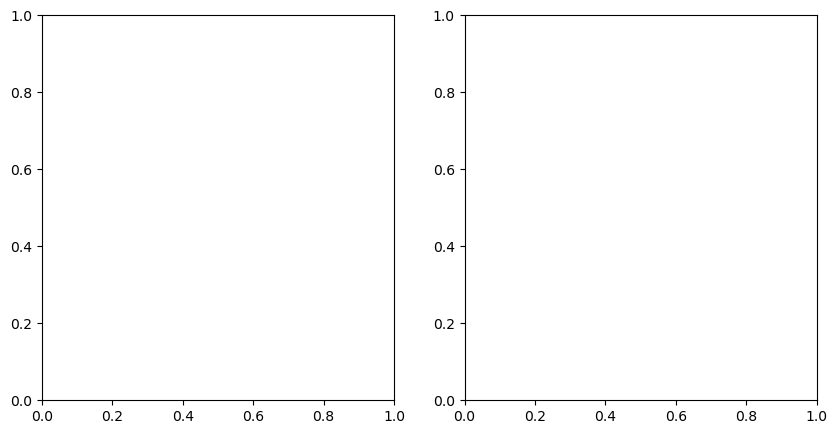

In [1]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.ravel()

ax[0].plot(train_accuracies, label='Train Accuracy')
ax[0].plot(val_accuracies, label='Val Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(train_losses, label='Train Loss')
ax[1].plot(val_losses, label='Val Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.show()
